In [ ]:
!python -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------------------------------- ---- 1.6/1.8 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install kmapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
pip install tqdm

#Grid Search for Mapper Parameters
This is code written to determine three parameters (`interval`, `overlap`, `clust`) for Mapper. Here we use NYU dataset with 222 subject. The search is cover 252 parameters.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA # Import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    # Initialize PCA to reduce data to 2 dimensions
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca, # Use the PCA-transformed data as the lens
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        # Call the new pca_mapper function instead of tsne_mapper
        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        # Use try-except blocks for centrality calculations
        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception:
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for subject_folder in subject_folders:
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1, 2, 3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Grid Search Main Function ---

def run_grid_search(root_folder):
    """
    Performs the grid search over the specified parameter ranges.
    """
    intervals = range(4, 11)
    overlaps = np.arange(0.1, 0.5, 0.1)
    clusters = range(2, 11)

    param_combinations = list(np.array(np.meshgrid(intervals, overlaps, clusters)).T.reshape(-1, 3))

    try:
        phenotypic_df = pd.read_csv('NYU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    all_results = []

    print(f"Starting Grid Search with {len(param_combinations)} parameter combinations...")
    print("This may take a very long time depending on the number of subjects.")

    for interval, overlap, clust in tqdm(param_combinations, desc="Grid Search Progress"):
        interval = int(interval)
        clust = int(clust)

        centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

        if centrality_df.empty:
            continue

        current_p_values = get_p_values(centrality_df, phenotypic_df.copy())

        # Optional: uncomment to print p-values for each grid point during the run
        # print(f"\nParams (Interval: {interval}, Overlap: {overlap:.1f}, Clusters: {clust}):")
        # for measure, p_val in current_p_values.items():
        #     print(f"  - {measure}: p={p_val:.6f}")

        result_row = {
            'interval': interval,
            'overlap': overlap,
            'clusters': clust
        }
        for measure, p_val in current_p_values.items():
            result_row[f'p_value_{measure}'] = p_val
        all_results.append(result_row)

    results_df = pd.DataFrame(all_results)
    results_df.to_csv('grid_search_p_values_pca.csv', index=False)
    print("\n" + "="*50)
    print("All p-values saved to 'grid_search_p_values_pca.csv'")
    print("="*50)

    p_value_cols = [col for col in results_df.columns if 'p_value' in col]
    if not results_df.empty and p_value_cols:
        min_val_series = results_df[p_value_cols].min()
        min_measure = min_val_series.idxmin()
        min_p_value = min_val_series.min()
        min_params = results_df.loc[results_df[min_measure] == min_p_value].iloc[0]

        max_p_value = results_df[p_value_cols].max().max()

        print(f"\n--- Overall Analysis ---")
        print(f"Overall Lowest P-value Found: {min_p_value:.6f}")
        print(f"  - Measure: {min_measure.replace('p_value_', '')}")
        print(f"  - Parameters: (Interval: {int(min_params['interval'])}, Overlap: {min_params['overlap']:.1f}, Clusters: {int(min_params['clusters'])})")
        print(f"\nOverall Largest P-value Found: {max_p_value:.6f}")
        print("\n" + "="*50)

# --- Execution ---
if __name__ == "__main__":
    ROOT_FOLDER = "ADHD200_CC200_TCs_filtfix/NYU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_grid_search(ROOT_FOLDER)

Starting Grid Search with 252 parameter combinations...
This may take a very long time depending on the number of subjects.


Grid Search Progress: 100%|████████████████████████████████████████████████████████| 252/252 [5:40:25<00:00, 81.05s/it]


All p-values saved to 'grid_search_p_values_pca.csv'

--- Overall Analysis ---
Overall Lowest P-value Found: 0.002729
  - Measure: betweenness_centrality
  - Parameters: (Interval: 8, Overlap: 0.4, Clusters: 9)

Overall Largest P-value Found: 1.000000



###NYU Dataset
The p-values for NYU datasets are calculated using the parameters `interval = 8`, `overlap = 0.4`, `clust = 9`. it calculates p-values of three centrality scores (betweenness, closeness, and degree) of the Mapper graphs of each subject. Then it compares the ADHD and TDC subjects.  

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception as e:
        # print(f"Error processing {folder_path}: {e}") # Optional: for debugging
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Use tqdm for a progress bar over subjects
    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1, 2, 3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Main Analysis Function ---

def run_single_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters.
    """
    # Define the fixed parameters
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('NYU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for the parameter set
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Calculate p-values for this run
    p_values_result = get_p_values(centrality_df, phenotypic_df.copy())

    # 3. Print the final results
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print("Calculated P-values:")
    for measure, p_val in p_values_result.items():
        print(f"  - {measure.replace('_', ' ').title()}: p = {p_val:.6f}")
    print("\n" + "="*50)


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "ADHD200_CC200_TCs_filtfix/NYU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_single_analysis(ROOT_FOLDER)

Running Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|█████████████████████████████████████████████| 222/222 [00:31<00:00,  7.09it/s]


ANALYSIS COMPLETE
Calculated P-values:
  - Closeness Centrality: p = 0.040595
  - Eigenvector Centrality: p = 1.000000
  - Betweenness Centrality: p = 0.002729
  - Degree Centrality: p = 0.165454



###OHSU Dataset
The p-values for OHSU datasets are calculated using the parameters `interval = 8`, `overlap = 0.4`, `clust = 9`. it calculates p-values of three centrality scores (betweenness, closeness, and degree) of the Mapper graphs of each subject. Then it compares the ADHD and TDC subjects.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception as e:
        # print(f"Error processing {folder_path}: {e}") # Optional: for debugging
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Use tqdm for a progress bar over subjects
    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1,2,3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Main Analysis Function ---

def run_single_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters.
    """
    # Define the fixed parameters
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('OHSU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for the parameter set
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Calculate p-values for this run
    p_values_result = get_p_values(centrality_df, phenotypic_df.copy())

    # 3. Print the final results
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print("Calculated P-values:")
    for measure, p_val in p_values_result.items():
        print(f"  - {measure.replace('_', ' ').title()}: p = {p_val:.6f}")
    print("\n" + "="*50)


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/OHSU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_single_analysis(ROOT_FOLDER)

Running Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|██████████| 79/79 [01:14<00:00,  1.07it/s]


ANALYSIS COMPLETE
Calculated P-values:
  - Closeness Centrality: p = 0.203605
  - Eigenvector Centrality: p = 1.000000
  - Betweenness Centrality: p = 0.124761
  - Degree Centrality: p = 0.352768



###NeuroIMAGE Dataset
The p-values for NeuroIMAGE datasets are calculated using the parameters `interval = 8`, `overlap = 0.4`, `clust = 9`. it calculates p-values of three centrality scores (betweenness, closeness, and degree) of the Mapper graphs of each subject. Then it compares the ADHD and TDC subjects.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception as e:
        # print(f"Error processing {folder_path}: {e}") # Optional: for debugging
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Use tqdm for a progress bar over subjects
    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1, 2, 3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Main Analysis Function ---

def run_single_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters.
    """
    # Define the fixed parameters
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('ADHD200_training_pheno/NeuroIMAGE/NeuroIMAGE_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for the parameter set
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Calculate p-values for this run
    p_values_result = get_p_values(centrality_df, phenotypic_df.copy())

    # 3. Print the final results
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print("Calculated P-values:")
    for measure, p_val in p_values_result.items():
        print(f"  - {measure.replace('_', ' ').title()}: p = {p_val:.6f}")
    print("\n" + "="*50)


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "ADHD200_CC200_TCs_filtfix/NeuroIMAGE"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_single_analysis(ROOT_FOLDER)

Running Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|███████████████████████████████████████████████| 48/48 [00:11<00:00,  4.33it/s]


ANALYSIS COMPLETE
Calculated P-values:
  - Closeness Centrality: p = 0.067625
  - Eigenvector Centrality: p = 1.000000
  - Betweenness Centrality: p = 0.097863
  - Degree Centrality: p = 0.007255



###NYU High/low Inattentiveness and Centrality scores

Running Centrality Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|█████████████████████████████████████████████| 222/222 [00:31<00:00,  7.09it/s]



Group Counts for Analysis:
Group
Low Inattentive (<50)     34
High Inattentive (>70)    28
Name: count, dtype: int64

--- Analysis for: Closeness Centrality ---
Low Inattentive Mean:  0.0580
High Inattentive Mean: 0.0649
T-statistic:           -0.8398
P-value:               0.4044
Result: No Statistically Significant Difference Found.


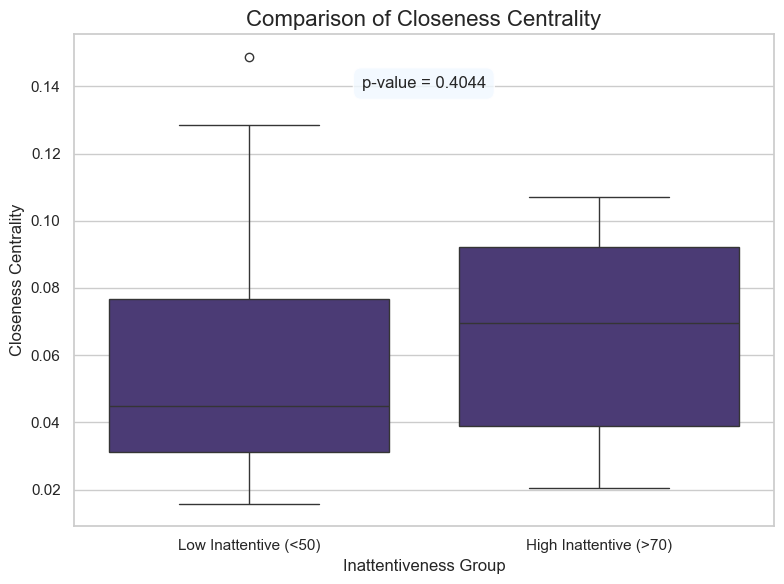


--- Analysis for: Eigenvector Centrality ---
Could not perform t-test: one or both groups have insufficient data.

--- Analysis for: Betweenness Centrality ---
Low Inattentive Mean:  0.0060
High Inattentive Mean: 0.0085
T-statistic:           -1.8808
P-value:               0.0656
Result: No Statistically Significant Difference Found.


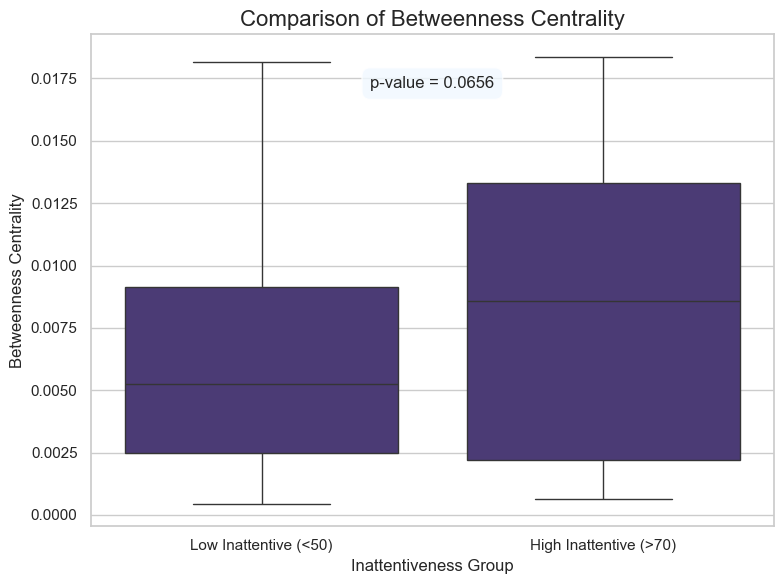


--- Analysis for: Degree Centrality ---
Low Inattentive Mean:  0.0167
High Inattentive Mean: 0.0170
T-statistic:           -0.2967
P-value:               0.7678
Result: No Statistically Significant Difference Found.


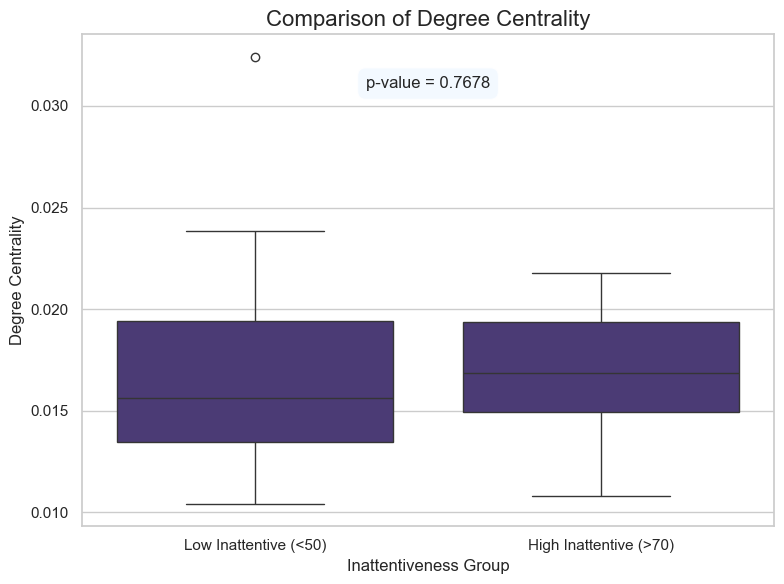

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    # Initialize PCA to reduce data to 2 dimensions for the lens
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        # Read and clean the data from the .1D file
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        # Generate the graph using the PCA mapper
        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        # Calculate centrality measures, handling potential errors for eigenvector centrality
        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception:
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function for Inattentiveness ---

def analyze_inattentiveness(centrality_df, phenotypic_df):
    """
    Merges data, groups by inattentiveness score, calculates p-values, and generates plots.
    """
    # Prepare phenotypic data for merging
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number', 'Inattentive': 'inattentive_score'}, inplace=True)

    # Ensure subject_number is the same type for merging
    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    # Merge the two dataframes
    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'inattentive_score']], on='subject_number', how='inner')

    # Convert inattentive_score to numeric, coercing errors to NaN
    merged_df['inattentive_score'] = pd.to_numeric(merged_df['inattentive_score'], errors='coerce')
    merged_df.dropna(subset=['inattentive_score'], inplace=True)

    # Create a new 'Group' column based on the inattentiveness score
    merged_df['Group'] = np.nan
    merged_df.loc[merged_df['inattentive_score'] < 50, 'Group'] = 'Low Inattentive (<50)'
    merged_df.loc[merged_df['inattentive_score'] > 70, 'Group'] = 'High Inattentive (>70)'

    # Filter out subjects not in either group
    analysis_df = merged_df.dropna(subset=['Group'])

    print("\n" + "="*50)
    print("Group Counts for Analysis:")
    print(analysis_df['Group'].value_counts())
    print("="*50)


    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    # Set plot style
    sns.set(style="whitegrid", palette="viridis")

    for measure in centrality_measures:
        print(f"\n--- Analysis for: {measure.replace('_', ' ').title()} ---")

        # Drop rows with missing values for the current centrality measure
        clean_df = analysis_df.dropna(subset=[measure])

        # Separate the data for the two groups
        low_inatt_scores = clean_df[clean_df['Group'] == 'Low Inattentive (<50)'][measure]
        high_inatt_scores = clean_df[clean_df['Group'] == 'High Inattentive (>70)'][measure]

        if len(low_inatt_scores) > 1 and len(high_inatt_scores) > 1:
            # --- Statistical Test (Welch's T-test) ---
            t_stat, p_value = ttest_ind(low_inatt_scores, high_inatt_scores, equal_var=False, nan_policy='omit')

            print(f"Low Inattentive Mean:  {low_inatt_scores.mean():.4f}")
            print(f"High Inattentive Mean: {high_inatt_scores.mean():.4f}")
            print(f"T-statistic:           {t_stat:.4f}")
            print(f"P-value:               {p_value:.4f}")

            if p_value < 0.05:
                print("Result: Statistically Significant Difference Found.")
            else:
                print("Result: No Statistically Significant Difference Found.")

            # --- Visualization (Box Plot) ---
            plt.figure(figsize=(8, 6))
            ax = sns.boxplot(x='Group', y=measure, data=clean_df, order=['Low Inattentive (<50)', 'High Inattentive (>70)'])
            plt.title(f"Comparison of {measure.replace('_', ' ').title()}", fontsize=16)
            plt.xlabel("Inattentiveness Group", fontsize=12)
            plt.ylabel(f"{measure.replace('_', ' ').title()}", fontsize=12)

            # Add p-value to the plot
            plt.text(0.5, 0.9, f'p-value = {p_value:.4f}',
                     horizontalalignment='center', verticalalignment='center',
                     transform=ax.transAxes, fontsize=12,
                     bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

            plt.tight_layout()
            plt.show()

        else:
            print("Could not perform t-test: one or both groups have insufficient data.")


# --- Main Analysis Function ---

def run_inattentiveness_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters, comparing low vs. high inattentiveness.
    """
    # Define the fixed parameters for Kepler-Mapper
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Centrality Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('NYU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for all subjects
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Run the statistical analysis comparing low vs. high inattentiveness
    analyze_inattentiveness(centrality_df, phenotypic_df.copy())


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "ADHD200_CC200_TCs_filtfix/NYU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the folder is in the same directory as your script.")
    else:
        run_inattentiveness_analysis(ROOT_FOLDER)


###OHSU High/low Inattentiveness and Centrality scores

Running Centrality Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|███████████████████████████████████████████████| 79/79 [00:05<00:00, 14.05it/s]



Group Counts for Analysis:
Group
Low Inattentive (<50)     23
High Inattentive (>70)    19
Name: count, dtype: int64

--- Analysis for: Closeness Centrality ---
Low Inattentive Mean:  0.0294
High Inattentive Mean: 0.0395
T-statistic:           -2.0383
P-value:               0.0491
Result: Statistically Significant Difference Found.


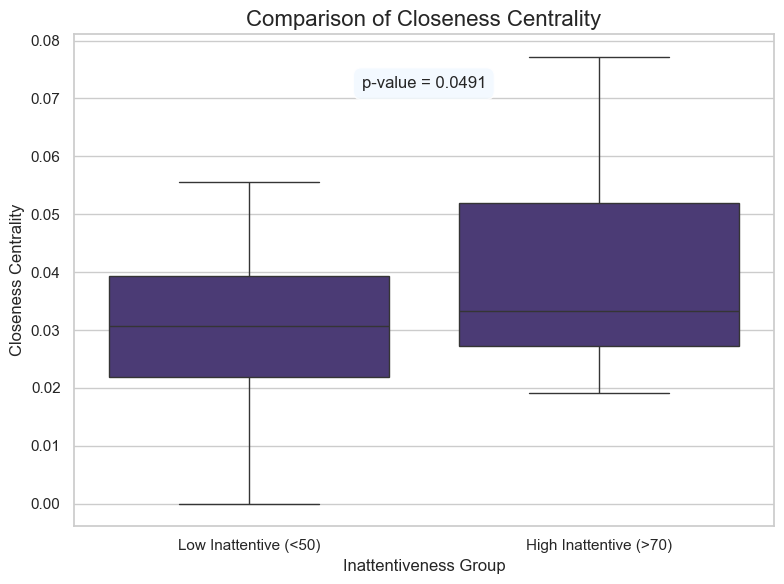


--- Analysis for: Eigenvector Centrality ---
Could not perform t-test: one or both groups have insufficient data.

--- Analysis for: Betweenness Centrality ---
Low Inattentive Mean:  0.0004
High Inattentive Mean: 0.0009
T-statistic:           -1.5961
P-value:               0.1239
Result: No Statistically Significant Difference Found.


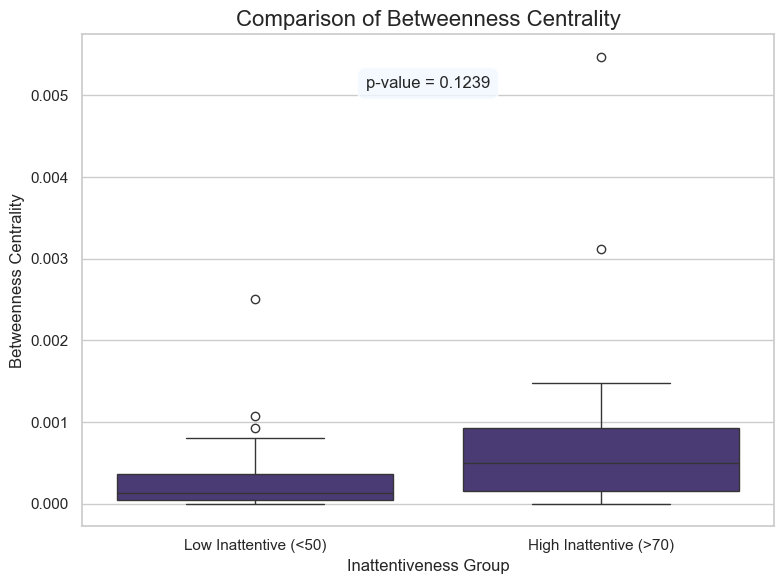


--- Analysis for: Degree Centrality ---
Low Inattentive Mean:  0.0263
High Inattentive Mean: 0.0319
T-statistic:           -1.6013
P-value:               0.1172
Result: No Statistically Significant Difference Found.


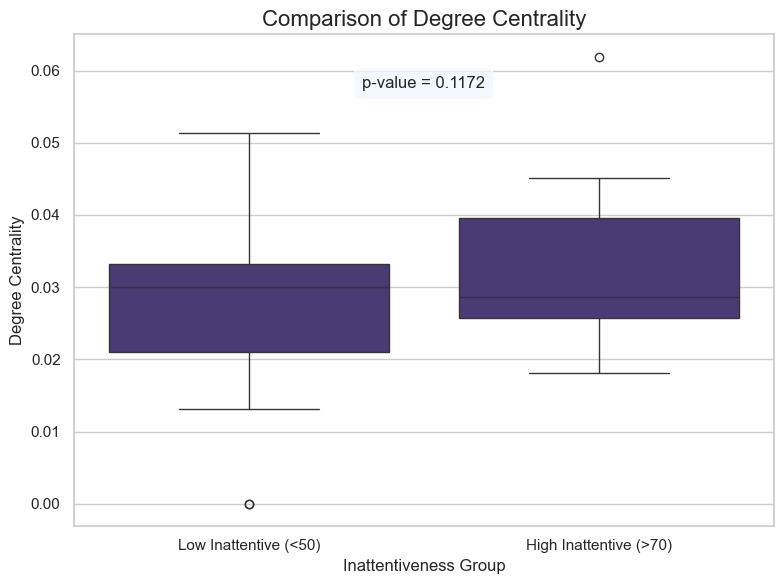

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    # Initialize PCA to reduce data to 2 dimensions for the lens
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        # Read and clean the data from the .1D file
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        # Generate the graph using the PCA mapper
        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        # Calculate centrality measures, handling potential errors for eigenvector centrality
        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception:
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function for Inattentiveness ---

def analyze_inattentiveness(centrality_df, phenotypic_df):
    """
    Merges data, groups by inattentiveness score, calculates p-values, and generates plots.
    """
    # Prepare phenotypic data for merging
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number', 'Inattentive': 'inattentive_score'}, inplace=True)

    # Ensure subject_number is the same type for merging
    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    # Merge the two dataframes
    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'inattentive_score']], on='subject_number', how='inner')

    # Convert inattentive_score to numeric, coercing errors to NaN
    merged_df['inattentive_score'] = pd.to_numeric(merged_df['inattentive_score'], errors='coerce')
    merged_df.dropna(subset=['inattentive_score'], inplace=True)

    # Create a new 'Group' column based on the inattentiveness score
    merged_df['Group'] = np.nan
    merged_df.loc[merged_df['inattentive_score'] < 50, 'Group'] = 'Low Inattentive (<50)'
    merged_df.loc[merged_df['inattentive_score'] > 70, 'Group'] = 'High Inattentive (>70)'

    # Filter out subjects not in either group
    analysis_df = merged_df.dropna(subset=['Group'])

    print("\n" + "="*50)
    print("Group Counts for Analysis:")
    print(analysis_df['Group'].value_counts())
    print("="*50)


    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    # Set plot style
    sns.set(style="whitegrid", palette="viridis")

    for measure in centrality_measures:
        print(f"\n--- Analysis for: {measure.replace('_', ' ').title()} ---")

        # Drop rows with missing values for the current centrality measure
        clean_df = analysis_df.dropna(subset=[measure])

        # Separate the data for the two groups
        low_inatt_scores = clean_df[clean_df['Group'] == 'Low Inattentive (<50)'][measure]
        high_inatt_scores = clean_df[clean_df['Group'] == 'High Inattentive (>70)'][measure]

        if len(low_inatt_scores) > 1 and len(high_inatt_scores) > 1:
            # --- Statistical Test (Welch's T-test) ---
            t_stat, p_value = ttest_ind(low_inatt_scores, high_inatt_scores, equal_var=False, nan_policy='omit')

            print(f"Low Inattentive Mean:  {low_inatt_scores.mean():.4f}")
            print(f"High Inattentive Mean: {high_inatt_scores.mean():.4f}")
            print(f"T-statistic:           {t_stat:.4f}")
            print(f"P-value:               {p_value:.4f}")

            if p_value < 0.05:
                print("Result: Statistically Significant Difference Found.")
            else:
                print("Result: No Statistically Significant Difference Found.")

            # --- Visualization (Box Plot) ---
            plt.figure(figsize=(8, 6))
            ax = sns.boxplot(x='Group', y=measure, data=clean_df, order=['Low Inattentive (<50)', 'High Inattentive (>70)'])
            plt.title(f"Comparison of {measure.replace('_', ' ').title()}", fontsize=16)
            plt.xlabel("Inattentiveness Group", fontsize=12)
            plt.ylabel(f"{measure.replace('_', ' ').title()}", fontsize=12)

            # Add p-value to the plot
            plt.text(0.5, 0.9, f'p-value = {p_value:.4f}',
                     horizontalalignment='center', verticalalignment='center',
                     transform=ax.transAxes, fontsize=12,
                     bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

            plt.tight_layout()
            plt.show()

        else:
            print("Could not perform t-test: one or both groups have insufficient data.")


# --- Main Analysis Function ---

def run_inattentiveness_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters, comparing low vs. high inattentiveness.
    """
    # Define the fixed parameters for Kepler-Mapper
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Centrality Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('ADHD200_training_pheno/OHSU/OHSU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for all subjects
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Run the statistical analysis comparing low vs. high inattentiveness
    analyze_inattentiveness(centrality_df, phenotypic_df.copy())


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "ADHD200_CC200_TCs_filtfix/OHSU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the folder is in the same directory as your script.")
    else:
        run_inattentiveness_analysis(ROOT_FOLDER)


###NYU High/low Impulsiveness and Centrality scores

Running Centrality Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|██████████| 222/222 [00:44<00:00,  4.98it/s]



Group Counts for Analysis:
Group
Low Impulsive (<50)     36
High Impulsive (>70)    24
Name: count, dtype: int64

--- Analysis for: Closeness Centrality ---
Low Impulsive Mean:  0.0561
High Impulsive Mean: 0.0712
T-statistic:           -1.6628
P-value:               0.1033
Result: No Statistically Significant Difference Found.


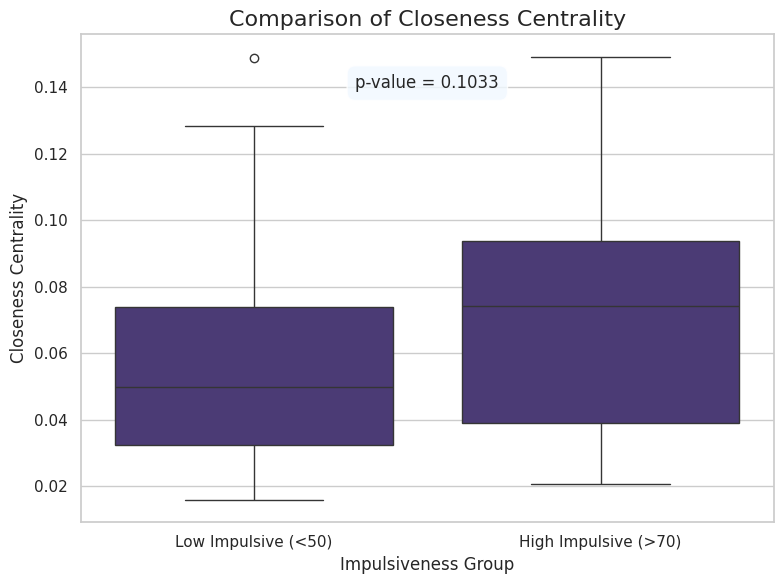


--- Analysis for: Eigenvector Centrality ---
Could not perform t-test: one or both groups have insufficient data.

--- Analysis for: Betweenness Centrality ---
Low Impulsive Mean:  0.0058
High Impulsive Mean: 0.0097
T-statistic:           -2.6688
P-value:               0.0113
Result: Statistically Significant Difference Found.


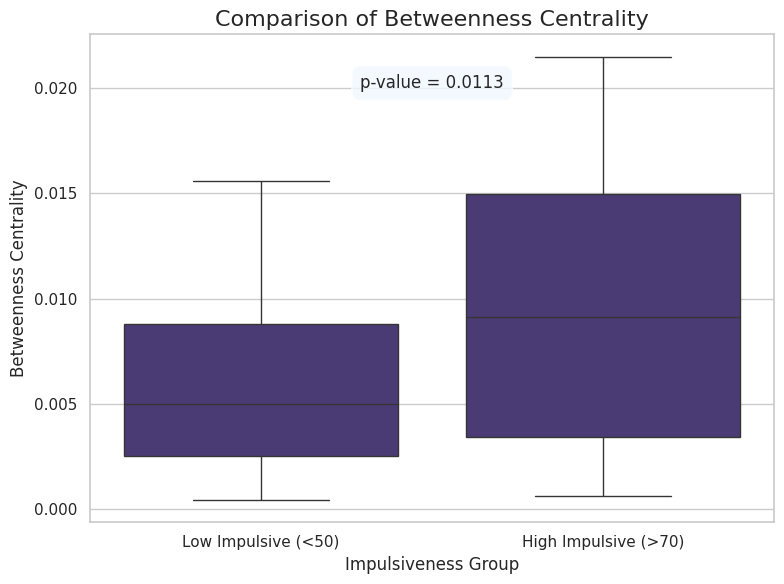


--- Analysis for: Degree Centrality ---
Low Impulsive Mean:  0.0165
High Impulsive Mean: 0.0178
T-statistic:           -1.3917
P-value:               0.1695
Result: No Statistically Significant Difference Found.


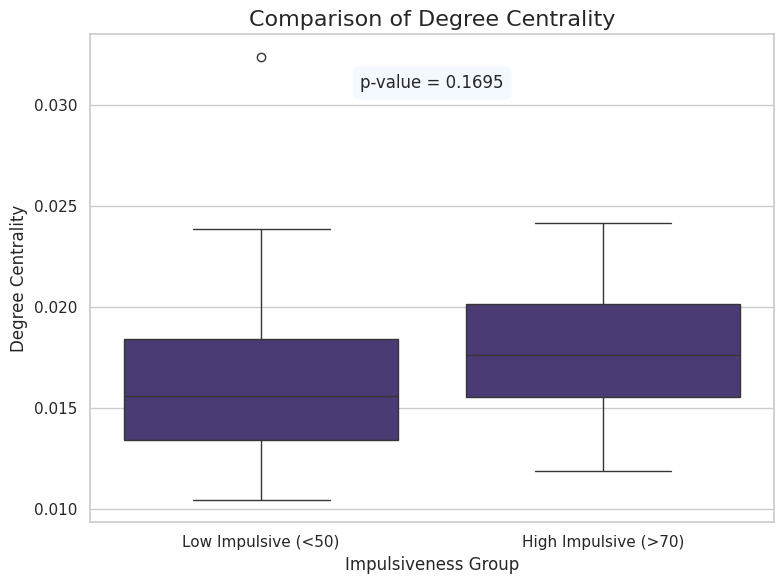

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    # Initialize PCA to reduce data to 2 dimensions for the lens
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        # Read and clean the data from the .1D file
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        # Generate the graph using the PCA mapper
        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        # Calculate centrality measures, handling potential errors for eigenvector centrality
        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception:
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function for Inattentiveness ---

def analyze_inattentiveness(centrality_df, phenotypic_df):
    """
    Merges data, groups by inattentiveness score, calculates p-values, and generates plots.
    """
    # Prepare phenotypic data for merging
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number', 'Hyper/Impulsive': 'impulsive_score'}, inplace=True)

    # Ensure subject_number is the same type for merging
    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    # Merge the two dataframes
    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'impulsive_score']], on='subject_number', how='inner')

    # Convert inattentive_score to numeric, coercing errors to NaN
    merged_df['impulsive_score'] = pd.to_numeric(merged_df['impulsive_score'], errors='coerce')
    merged_df.dropna(subset=['impulsive_score'], inplace=True)

    # Create a new 'Group' column based on the inattentiveness score
    merged_df['Group'] = np.nan
    merged_df.loc[merged_df['impulsive_score'] < 50, 'Group'] = 'Low Impulsive (<50)'
    merged_df.loc[merged_df['impulsive_score'] > 70, 'Group'] = 'High Impulsive (>70)'

    # Filter out subjects not in either group
    analysis_df = merged_df.dropna(subset=['Group'])

    print("\n" + "="*50)
    print("Group Counts for Analysis:")
    print(analysis_df['Group'].value_counts())
    print("="*50)


    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    # Set plot style
    sns.set(style="whitegrid", palette="viridis")

    for measure in centrality_measures:
        print(f"\n--- Analysis for: {measure.replace('_', ' ').title()} ---")

        # Drop rows with missing values for the current centrality measure
        clean_df = analysis_df.dropna(subset=[measure])

        # Separate the data for the two groups
        low_inatt_scores = clean_df[clean_df['Group'] == 'Low Impulsive (<50)'][measure]
        high_inatt_scores = clean_df[clean_df['Group'] == 'High Impulsive (>70)'][measure]

        if len(low_inatt_scores) > 1 and len(high_inatt_scores) > 1:
            # --- Statistical Test (Welch's T-test) ---
            t_stat, p_value = ttest_ind(low_inatt_scores, high_inatt_scores, equal_var=False, nan_policy='omit')

            print(f"Low Impulsive Mean:  {low_inatt_scores.mean():.4f}")
            print(f"High Impulsive Mean: {high_inatt_scores.mean():.4f}")
            print(f"T-statistic:           {t_stat:.4f}")
            print(f"P-value:               {p_value:.4f}")

            if p_value < 0.05:
                print("Result: Statistically Significant Difference Found.")
            else:
                print("Result: No Statistically Significant Difference Found.")

            # --- Visualization (Box Plot) ---
            plt.figure(figsize=(8, 6))
            ax = sns.boxplot(x='Group', y=measure, data=clean_df, order=['Low Impulsive (<50)', 'High Impulsive (>70)'])
            plt.title(f"Comparison of {measure.replace('_', ' ').title()}", fontsize=16)
            plt.xlabel("Impulsiveness Group", fontsize=12)
            plt.ylabel(f"{measure.replace('_', ' ').title()}", fontsize=12)

            # Add p-value to the plot
            plt.text(0.5, 0.9, f'p-value = {p_value:.4f}',
                     horizontalalignment='center', verticalalignment='center',
                     transform=ax.transAxes, fontsize=12,
                     bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

            plt.tight_layout()
            plt.show()

        else:
            print("Could not perform t-test: one or both groups have insufficient data.")


# --- Main Analysis Function ---

def run_inattentiveness_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters, comparing low vs. high inattentiveness.
    """
    # Define the fixed parameters for Kepler-Mapper
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Centrality Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('NYU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for all subjects
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Run the statistical analysis comparing low vs. high inattentiveness
    analyze_inattentiveness(centrality_df, phenotypic_df.copy())


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/NYU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the folder is in the same directory as your script.")
    else:
        run_inattentiveness_analysis(ROOT_FOLDER)


###OHSU High/low Impulsiveness and Centrality scores

Running Centrality Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|██████████| 79/79 [00:13<00:00,  6.03it/s]



Group Counts for Analysis:
Group
Low Impulsive (<50)     30
High Impulsive (>70)    18
Name: count, dtype: int64

--- Analysis for: Closeness Centrality ---
Low Impulsive Mean:  0.0300
High Impulsive Mean: 0.0346
T-statistic:           -1.0109
P-value:               0.3191
Result: No Statistically Significant Difference Found.


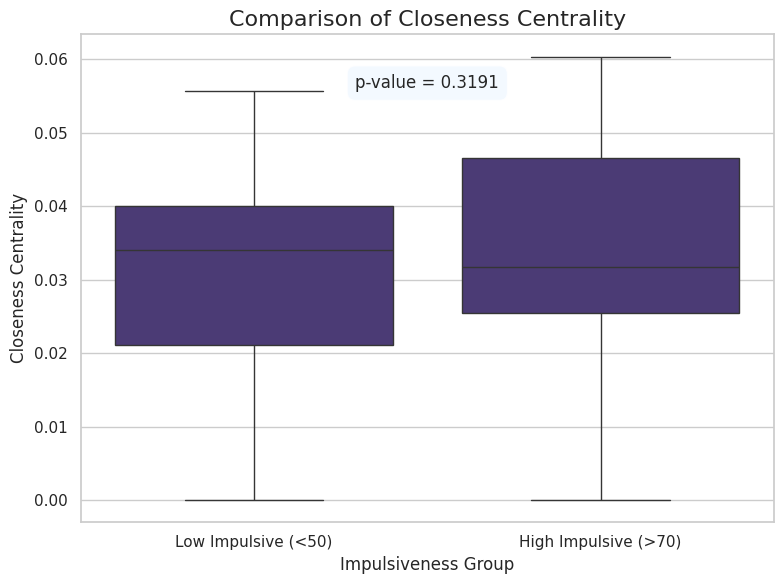


--- Analysis for: Eigenvector Centrality ---
Could not perform t-test: one or both groups have insufficient data.

--- Analysis for: Betweenness Centrality ---
Low Impulsive Mean:  0.0004
High Impulsive Mean: 0.0004
T-statistic:           -0.2743
P-value:               0.7853
Result: No Statistically Significant Difference Found.


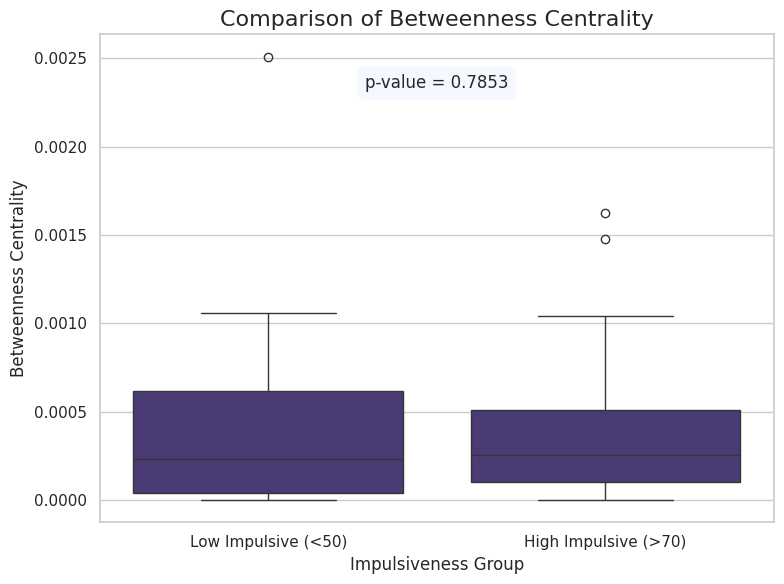


--- Analysis for: Degree Centrality ---
Low Impulsive Mean:  0.0260
High Impulsive Mean: 0.0297
T-statistic:           -1.0212
P-value:               0.3138
Result: No Statistically Significant Difference Found.


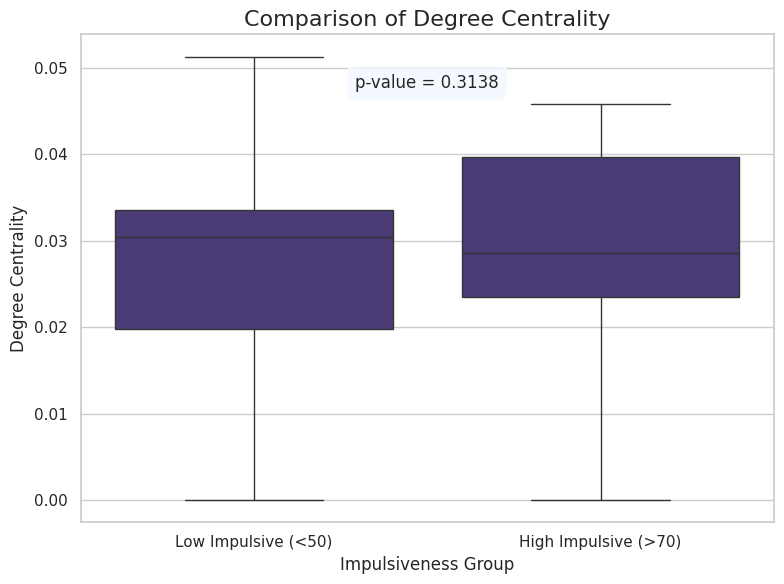

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    # Initialize PCA to reduce data to 2 dimensions for the lens
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        # Read and clean the data from the .1D file
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        # Generate the graph using the PCA mapper
        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        # Calculate centrality measures, handling potential errors for eigenvector centrality
        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception:
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function for Inattentiveness ---

def analyze_inattentiveness(centrality_df, phenotypic_df):
    """
    Merges data, groups by inattentiveness score, calculates p-values, and generates plots.
    """
    # Prepare phenotypic data for merging
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number', 'Hyper/Impulsive': 'impulsive_score'}, inplace=True)

    # Ensure subject_number is the same type for merging
    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    # Merge the two dataframes
    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'impulsive_score']], on='subject_number', how='inner')

    # Convert inattentive_score to numeric, coercing errors to NaN
    merged_df['impulsive_score'] = pd.to_numeric(merged_df['impulsive_score'], errors='coerce')
    merged_df.dropna(subset=['impulsive_score'], inplace=True)

    # Create a new 'Group' column based on the inattentiveness score
    merged_df['Group'] = np.nan
    merged_df.loc[merged_df['impulsive_score'] < 50, 'Group'] = 'Low Impulsive (<50)'
    merged_df.loc[merged_df['impulsive_score'] > 70, 'Group'] = 'High Impulsive (>70)'

    # Filter out subjects not in either group
    analysis_df = merged_df.dropna(subset=['Group'])

    print("\n" + "="*50)
    print("Group Counts for Analysis:")
    print(analysis_df['Group'].value_counts())
    print("="*50)


    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    # Set plot style
    sns.set(style="whitegrid", palette="viridis")

    for measure in centrality_measures:
        print(f"\n--- Analysis for: {measure.replace('_', ' ').title()} ---")

        # Drop rows with missing values for the current centrality measure
        clean_df = analysis_df.dropna(subset=[measure])

        # Separate the data for the two groups
        low_inatt_scores = clean_df[clean_df['Group'] == 'Low Impulsive (<50)'][measure]
        high_inatt_scores = clean_df[clean_df['Group'] == 'High Impulsive (>70)'][measure]

        if len(low_inatt_scores) > 1 and len(high_inatt_scores) > 1:
            # --- Statistical Test (Welch's T-test) ---
            t_stat, p_value = ttest_ind(low_inatt_scores, high_inatt_scores, equal_var=False, nan_policy='omit')

            print(f"Low Impulsive Mean:  {low_inatt_scores.mean():.4f}")
            print(f"High Impulsive Mean: {high_inatt_scores.mean():.4f}")
            print(f"T-statistic:           {t_stat:.4f}")
            print(f"P-value:               {p_value:.4f}")

            if p_value < 0.05:
                print("Result: Statistically Significant Difference Found.")
            else:
                print("Result: No Statistically Significant Difference Found.")

            # --- Visualization (Box Plot) ---
            plt.figure(figsize=(8, 6))
            ax = sns.boxplot(x='Group', y=measure, data=clean_df, order=['Low Impulsive (<50)', 'High Impulsive (>70)'])
            plt.title(f"Comparison of {measure.replace('_', ' ').title()}", fontsize=16)
            plt.xlabel("Impulsiveness Group", fontsize=12)
            plt.ylabel(f"{measure.replace('_', ' ').title()}", fontsize=12)

            # Add p-value to the plot
            plt.text(0.5, 0.9, f'p-value = {p_value:.4f}',
                     horizontalalignment='center', verticalalignment='center',
                     transform=ax.transAxes, fontsize=12,
                     bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

            plt.tight_layout()
            plt.show()

        else:
            print("Could not perform t-test: one or both groups have insufficient data.")


# --- Main Analysis Function ---

def run_inattentiveness_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters, comparing low vs. high inattentiveness.
    """
    # Define the fixed parameters for Kepler-Mapper
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Centrality Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('OHSU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'OHSU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for all subjects
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Run the statistical analysis comparing low vs. high inattentiveness
    analyze_inattentiveness(centrality_df, phenotypic_df.copy())


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/OHSU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the folder is in the same directory as your script.")
    else:
        run_inattentiveness_analysis(ROOT_FOLDER)


###NYU centrality scores are saved in .csv

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception as e:
        # print(f"Error processing {folder_path}: {e}") # Optional: for debugging
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Use tqdm for a progress bar over subjects
    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1,2,3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Main Analysis Function ---

def run_single_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters.
    """
    # Define the fixed parameters
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('NYU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for the parameter set
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Save the centrality scores to a CSV file
    output_filename = "centrality_scores.csv"
    centrality_df.to_csv(output_filename, index=False)
    print(f"\nCentrality scores for all subjects have been saved to '{output_filename}'")


    # 3. Calculate p-values for this run
    p_values_result = get_p_values(centrality_df, phenotypic_df.copy())

    # 4. Print the final results
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print("Calculated P-values:")
    for measure, p_val in p_values_result.items():
        print(f"  - {measure.replace('_', ' ').title()}: p = {p_val:.6f}")
    print("\n" + "="*50)


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/NYU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_single_analysis(ROOT_FOLDER)


Running Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|██████████| 222/222 [02:32<00:00,  1.46it/s]


Centrality scores for all subjects have been saved to 'centrality_scores.csv'

ANALYSIS COMPLETE
Calculated P-values:
  - Closeness Centrality: p = 0.040595
  - Eigenvector Centrality: p = 1.000000
  - Betweenness Centrality: p = 0.002729
  - Degree Centrality: p = 0.165454



###NeuroIMAGE centrality scores are saved in .csv

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception as e:
        # print(f"Error processing {folder_path}: {e}") # Optional: for debugging
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Use tqdm for a progress bar over subjects
    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1,2,3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Main Analysis Function ---

def run_single_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters.
    """
    # Define the fixed parameters
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('NeuroIMAGE_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for the parameter set
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Save the centrality scores to a CSV file
    output_filename = "centrality_scores.csv"
    centrality_df.to_csv(output_filename, index=False)
    print(f"\nCentrality scores for all subjects have been saved to '{output_filename}'")


    # 3. Calculate p-values for this run
    p_values_result = get_p_values(centrality_df, phenotypic_df.copy())

    # 4. Print the final results
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print("Calculated P-values:")
    for measure, p_val in p_values_result.items():
        print(f"  - {measure.replace('_', ' ').title()}: p = {p_val:.6f}")
    print("\n" + "="*50)


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/NeuroIMAGE"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_single_analysis(ROOT_FOLDER)


Running Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|██████████| 48/48 [00:42<00:00,  1.13it/s]


Centrality scores for all subjects have been saved to 'centrality_scores.csv'

ANALYSIS COMPLETE
Calculated P-values:
  - Closeness Centrality: p = 0.067625
  - Eigenvector Centrality: p = 1.000000
  - Betweenness Centrality: p = 0.097863
  - Degree Centrality: p = 0.007255



###OHSU centrality scores are saved in .csv

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from scipy.stats import ttest_ind
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Mapper and Centrality Calculation Functions ---

def pca_mapper(cdata, interval, overlap, clust):
    """
    Applies the PCA transformation and returns the mapper graph.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pd.DataFrame(pca.fit_transform(cdata), columns=['C0', 'C1'])

    mapper = km.KeplerMapper(verbose=0)

    graph = mapper.map(
        lens=data_pca,
        X=cdata,
        cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
        clusterer=AgglomerativeClustering(n_clusters=clust)
    )
    return graph

def process_subject_folder(folder_path, interval, overlap, clust):
    """
    Process a single subject folder and return centrality measures for a given parameter set.
    """
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        return None

    first_1d_file = sorted(one_d_files)[0]

    try:
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            return None

        graph = pca_mapper(data, interval=interval, overlap=overlap, clust=clust)
        nx_graph = km.adapter.to_nx(graph)

        if len(nx_graph.nodes()) == 0:
            return None

        try:
            eigenvector_cent = np.mean(list(nx.eigenvector_centrality_numpy(nx_graph).values()))
        except:
            eigenvector_cent = np.nan

        return {
            'eigenvector_centrality': eigenvector_cent,
            'betweenness_centrality': np.mean(list(nx.betweenness_centrality(nx_graph).values())),
            'closeness_centrality': np.mean(list(nx.closeness_centrality(nx_graph).values())),
            'degree_centrality': np.mean(list(nx.degree_centrality(nx_graph).values()))
        }
    except Exception as e:
        # print(f"Error processing {folder_path}: {e}") # Optional: for debugging
        return None

def calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust):
    """
    Processes all subject folders for a single set of parameters and returns a DataFrame.
    """
    results = []
    subject_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Use tqdm for a progress bar over subjects
    for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
        folder_path = os.path.join(root_folder, subject_folder)
        centrality_values = process_subject_folder(folder_path, interval, overlap, clust)

        if centrality_values:
            centrality_values['subject_number'] = subject_folder
            results.append(centrality_values)

    return pd.DataFrame(results)

# --- Statistical Analysis Function ---

def get_p_values(centrality_df, phenotypic_df):
    """
    Merges data and calculates p-values for all centrality measures.
    """
    phenotypic_df.rename(columns={'ScanDir ID': 'subject_number'}, inplace=True)

    centrality_df['subject_number'] = centrality_df['subject_number'].astype(str)
    phenotypic_df['subject_number'] = phenotypic_df['subject_number'].astype(str)

    merged_df = pd.merge(centrality_df, phenotypic_df[['subject_number', 'DX']], on='subject_number', how='inner')

    merged_df['Group'] = merged_df['DX'].apply(lambda x: 'ADHD' if x in [1,2,3] else 'TDC')

    p_values = {}
    centrality_measures = ['closeness_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'degree_centrality']

    for measure in centrality_measures:
        clean_df = merged_df.dropna(subset=[measure, 'Group'])
        adhd_scores = clean_df[clean_df['Group'] == 'ADHD'][measure]
        tdc_scores = clean_df[clean_df['Group'] == 'TDC'][measure]

        if len(adhd_scores) > 1 and len(tdc_scores) > 1:
            _, p_value = ttest_ind(adhd_scores, tdc_scores, equal_var=False, nan_policy='omit')
            p_values[measure] = p_value
        else:
            p_values[measure] = 1.0

    return p_values

# --- Main Analysis Function ---

def run_single_analysis(root_folder):
    """
    Performs the analysis for a single, fixed set of parameters.
    """
    # Define the fixed parameters
    interval = 8
    overlap = 0.4
    clust = 9

    print("="*50)
    print("Running Analysis with Fixed Parameters:")
    print(f"  - Interval: {interval}")
    print(f"  - Overlap:  {overlap}")
    print(f"  - Clusters: {clust}")
    print("="*50)

    # Load phenotypic data once
    try:
        phenotypic_df = pd.read_csv('OHSU_phenotypic.csv')
    except FileNotFoundError:
        print("ERROR: 'NYU_phenotypic.csv' not found. Please make sure the file is in the correct directory.")
        return

    # 1. Calculate centrality scores for the parameter set
    centrality_df = calculate_centrality_for_all_subjects(root_folder, interval, overlap, clust)

    if centrality_df.empty:
        print("\nCould not generate centrality data. Please check input files and paths.")
        return

    # 2. Save the centrality scores to a CSV file
    output_filename = "centrality_scores.csv"
    centrality_df.to_csv(output_filename, index=False)
    print(f"\nCentrality scores for all subjects have been saved to '{output_filename}'")


    # 3. Calculate p-values for this run
    p_values_result = get_p_values(centrality_df, phenotypic_df.copy())

    # 4. Print the final results
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print("Calculated P-values:")
    for measure, p_val in p_values_result.items():
        print(f"  - {measure.replace('_', ' ').title()}: p = {p_val:.6f}")
    print("\n" + "="*50)


# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/OHSU"

    if not os.path.isdir(ROOT_FOLDER):
        print(f"ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        run_single_analysis(ROOT_FOLDER)


Running Analysis with Fixed Parameters:
  - Interval: 8
  - Overlap:  0.4
  - Clusters: 9


Processing Subjects: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Centrality scores for all subjects have been saved to 'centrality_scores.csv'

ANALYSIS COMPLETE
Calculated P-values:
  - Closeness Centrality: p = 0.203605
  - Eigenvector Centrality: p = 1.000000
  - Betweenness Centrality: p = 0.124761
  - Degree Centrality: p = 0.352768



###This code is creating the MAPPER graphs htmls for two subjects 001006 and 1099481 in NYU dataset.
This graphs are interactive. Images are in the the paper.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def generate_mapper_graph_for_subject(subject_id, root_folder, interval, overlap, clust):
    """
    Loads data for a single subject, generates the KeplerMapper graph,
    and saves it as an interactive HTML file.
    """
    print(f"\nProcessing subject: {subject_id}...")
    folder_path = os.path.join(root_folder, str(subject_id))

    # Check if the subject folder exists
    if not os.path.isdir(folder_path):
        print(f"  - ERROR: Directory not found for subject {subject_id} at {folder_path}")
        return

    # Find the first .1D file in the directory
    one_d_files = glob.glob(os.path.join(folder_path, '*.1D'))
    if not one_d_files:
        print(f"  - ERROR: No .1D files found for subject {subject_id}")
        return

    first_1d_file = sorted(one_d_files)[0]
    print(f"  - Reading data from: {os.path.basename(first_1d_file)}")

    try:
        # Load and preprocess the data
        data = pd.read_csv(first_1d_file, header=None, skiprows=1, delimiter=r'\s+')
        data = data.iloc[1:, 1:]
        data = data.reset_index(drop=True)
        data.columns = range(len(data.columns))
        data = data.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=0).dropna(how='all', axis=1)

        if data.empty or data.shape[0] < 2 or data.shape[1] < 2:
            print(f"  - ERROR: Data for subject {subject_id} is empty or invalid after cleaning.")
            return

        # --- KeplerMapper Pipeline ---
        # 1. Initialize Mapper
        mapper = km.KeplerMapper(verbose=0)

        # 2. Define the lens (filter function) using PCA
        pca = PCA(n_components=2, random_state=42)
        data_pca = pca.fit_transform(data)

        # 3. Generate the graph dictionary
        graph = mapper.map(
            lens=data_pca,
            X=data,
            cover=km.Cover(n_cubes=interval, perc_overlap=overlap),
            # Corrected the AgglomerativeClustering call by removing the 'affinity' argument
            clusterer=AgglomerativeClustering(n_clusters=clust, linkage='complete')
        )

        # 4. Visualize the graph and save to HTML
        output_filename = f"mapper_graph_{subject_id}.html"
        print(f"  - Generating visualization: {output_filename}")

        mapper.visualize(
            graph,
            path_html=output_filename,
            title=f"Mapper Graph for Subject {subject_id}",
            custom_tooltips=np.array([f'Point {i}' for i in range(data.shape[0])]) # Example tooltips
        )
        print(f"  - Successfully created {output_filename}")

    except Exception as e:
        print(f"  - An unexpected error occurred while processing subject {subject_id}: {e}")

# --- Execution ---
if __name__ == "__main__":
    # This path should be relative to where your script is located.
    ROOT_FOLDER = "/content/drive/MyDrive/NYU"
    SUBJECT_IDS = ['0010046', '1099481']

    # Fixed parameters from your script
    INTERVAL = 8
    OVERLAP = 0.4
    CLUSTERS = 9

    print("="*50)
    print("Generating Mapper Graphs for Specific Subjects")
    print(f"Parameters: Interval={INTERVAL}, Overlap={OVERLAP}, Clusters={CLUSTERS}")
    print("="*50)


    if not os.path.isdir(ROOT_FOLDER):
        print(f"FATAL ERROR: The specified root folder does not exist: {ROOT_FOLDER}")
        print("Please make sure the 'ADHD200_CC200_TCs_filtfix' folder is in the same directory as your script.")
    else:
        for subject in SUBJECT_IDS:
            generate_mapper_graph_for_subject(subject, ROOT_FOLDER, INTERVAL, OVERLAP, CLUSTERS)
        print("\n" + "="*50)
        print("Processing complete.")
        print("="*50)


Generating Mapper Graphs for Specific Subjects
Parameters: Interval=8, Overlap=0.4, Clusters=9

Processing subject: 0010046...
  - Reading data from: sfnwmrda0010046_session_1_rest_1_cc200_TCs.1D
  - Generating visualization: mapper_graph_0010046.html
  - Successfully created mapper_graph_0010046.html

Processing subject: 1099481...
  - Reading data from: sfnwmrda1099481_session_1_rest_1_cc200_TCs.1D
  - Generating visualization: mapper_graph_1099481.html
  - Successfully created mapper_graph_1099481.html

Processing complete.
